In [78]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from warnings import catch_warnings, simplefilter

def f(X):
    return -X[:,0] + (X[:,1]-X[:,2])*np.cos(X[:,0]) - X[:,3]**2

X_range = [(0,1), (0,1), (0,1), (0,1)]
X = np.zeros((10000,len(X_range)))
for i,lims in enumerate(X_range):
    X[:,i] = np.random.uniform(lims[0],lims[1],10000)
    
Y = f(X)
X_opt = X[Y.argmax(),:]

print("Inputs: ", X_opt, " gave max value of: ", Y.max())

Inputs:  [0.03372386 0.98923099 0.02554182 0.31245677]  gave max value of:  0.8317881316882177


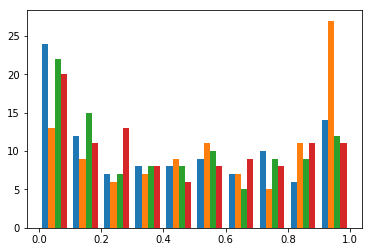

Bayes estimate:  [0.05813662 0.93671219 0.00506352 0.28746649]  with true value  [0.78930108]
True optimal:  [0.03372386 0.98923099 0.02554182 0.31245677]  with true value  [0.83178813]


In [79]:
def get_random_samples(X_range, n_random):
    X = np.zeros((n_random, len(X_range)))
    for i,lims in enumerate(X_range):
        X[:,i] = np.random.uniform(lims[0],lims[1],n_random)
    
    return X


def expected_improvement(X, X_sample, y_sample, model):
    """Return EI at each point in X.
    
    Computes EI at points X based on sampled data X_sample and Y_sample
    """
    with catch_warnings():
        # Ignore some weird sklearn errors in prediction
        simplefilter("ignore")
        mu, sigma = model.predict(X, return_std=True)  # Get mean and variance at X
        opt = y_sample.max()  # Current optimal
        mu = mu.reshape(-1,1)
        sigma = sigma.reshape(-1,1)

        imp = mu - opt  # Improvement is the mean for a given x minus the current optimal
        Z = imp / sigma  # Convert that to a z-score
                
        # This basically integrates from -inf up to Z and factors in the probability of actually
        # getting the improvement value imp. We want the optimal expected improvement not just the 
        # highest best-case improvement.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

        return ei
    

def opt_acquisition(X_sample, X_range, y_sample, model, n_surrogate):
    """Returns the X sample that optimizes the acquisition function"""
    X = get_random_samples(X_range, n_surrogate)
    scores = expected_improvement(X, X_sample, y_sample, model)
    return X[scores.argmax(), :].reshape(1,-1)


def bayes_opt(objective, n_random, n_bayes, X_range, n_surrogate=100):
    """Perform Bayesian optimization on the objective function.
    
    Args:
        objective(function): The objective function to maximize.
        n_random(int): The number of random samples to gather before
            starting the bayesian optimization loops.
        n_bayes(int): The number of Bayesian optimization loops to run.
        X_range(list): List of (low_bound, up_bound) tuples giving the range
            for each of the variables of the objective function.
        n_surrogate(int, optional): The number of random samples to evaluate
            on the surrogate model before evaluating the best option on the 
            objective function. Default 100.
            
    Returns:
        List of length n_inputs containing the inputs to the objective function
        that maximizes the return value.
    """
    X_sample = get_random_samples(X_range, n_random)
    y_sample = objective(X_sample).reshape(-1,1)
        
    model = GaussianProcessRegressor()
    
    for _ in range(n_bayes):
        # Fit model to current data
        model.fit(X_sample, y_sample)

        # Find next x that optimizes expected improvement
        x = opt_acquisition(X_sample, X_range, y_sample, model, n_surrogate)
        
        # Evaluate that x
        y = objective(x)
                
        X_sample = np.vstack((X_sample, x))
        y_sample = np.vstack((y_sample, y))
        
    plt.hist(X_sample)
    plt.show()
    return X_sample[y_sample.argmax()]
    
        
X_range = [(0,1), (0,1), (0,1), (0,1)]
X_bayes = bayes_opt(f, 5, 100, X_range)

print("Bayes estimate: ", X_bayes, " with true value ", f(X_bayes.reshape(1,-1)))
print("True optimal: ", X_opt, " with true value ", f(X_opt.reshape(1,-1)))